<h1 align="center"> Computation for Physicists </h1>
<h2 align="center"> <em>Interpolation</em> </h2>
<h2 align="center" > <a href="mailto:duan@unm.edu">Dr. Duan</a> (UNM) </h2>

# Homework 10

Radar uses short radio frequency pulses to identify objects and their distances.  This is done by emitting a pulse and timing how long it takes for an echo to be received.  The distance to the object is then half of the transmit-receive delay divided by the speed of light.  You can do something similar with sound to estimate distances to objects.  I have recorded a short wav file of me transmitting a series of three clicks in my office and have posted it at https://fornax.phys.unm.edu/lwa/data/for_c4p/ms.wav.  Load the sound file and correlate it to estimate the distance to the strongest echo for each click.
 
 * Hint #1 - You can load a wav file with the `scipy.io.wavfile` module.  This will also give you the sample rate in Hz to help convert samples to time.
 * Hint #2 - The wav file saves `numpy.int16` data.  You will want to convert to `numpy.float32` for analysis.

In [1]:
import numpy as np
from scipy.io import wavfile
from scipy.fft import rfft, irfft
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg') # make sharp images

In [2]:
# load and check data
samplerate, data = wavfile.read('homework/ms.wav')
samplerate, data.shape, data.dtype

(44100, (48064, 2), dtype('int16'))

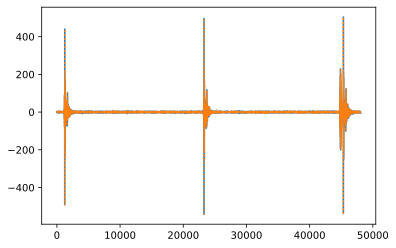

In [3]:
plt.plot(data[:,0]) # sound amplitude in channel 1
plt.plot(data[:,1], ':') # channel 2
plt.show()

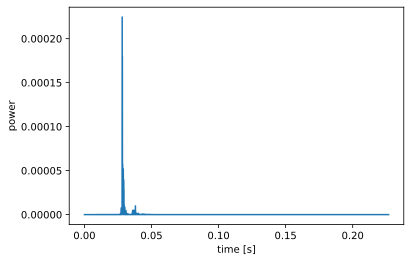

In [4]:
# Extract the power of the first pulse
imax = 10000 # cutoff index for the first pulse
power = np.mean((data[:imax, :]/2**15)**2, axis=1) # average power
t = np.arange(len(power)) / samplerate # time in seconds
plt.plot(t, power)
plt.ylabel('power')
plt.xlabel('time [s]')
plt.show()

Auto-correlation function
$$ R_{ff}(t) = \int_{-\infty}^\infty f(t'+t) f(t')\,\mathrm{d} t'
= \mathcal{F}^{-1}[|\tilde{f}(\omega)|^2]$$
finds repeating patterns in a signal.

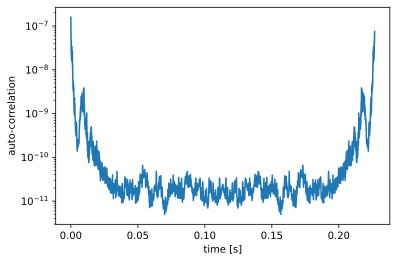

In [5]:
# Compute the auto-correlation by FFT
corr = irfft(np.abs(rfft(power))**2)
plt.semilogy(t, corr)
plt.xlabel('time [s]')
plt.ylabel('auto-correlation')
plt.show()

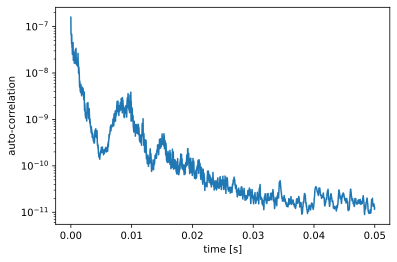

In [6]:
# zoom in to find the first peak
b = int(0.05*samplerate) # bracketing the first peak
plt.semilogy(t[:b], corr[:b])
plt.xlabel('time [s]')
plt.ylabel('auto-correlation')
plt.show()

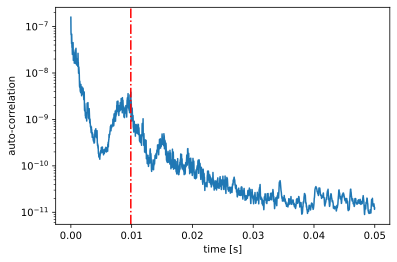

In [7]:
# localize the first peak
a = int(0.005*samplerate) # lower bound of the first peak
ind = np.argmax(corr[a:b]) + a # index of the first peak
plt.semilogy(t[:b], corr[:b])
plt.axvline(t[ind], ls='-.', color='r') # mark the first peak
plt.xlabel('time [s]')
plt.ylabel('auto-correlation')
plt.show()

In [8]:
# compute the distance
v = 343 # speed of sound in m/s
print(f'The distance is {v*t[ind]/2:.1f} meters.')

The distance is 1.7 meters.


# Interpolation 

- For a given data set $\{(t_i, y_i):\, i=0,1,\ldots,n-1\}$, determine an _interpolating function_ or _interpolant_ $f(t)$ so that $f(t_i)=y_i$.

- Interpolation is used for
    - plotting smooth curves,
    - estimating values not included in the data,
    - differentiating or integrating the data,
    - replacing complicated functions by simpler ones,
    - ...

- An interpolant
$$ f(t) = \sum_{i=0}^{n-1} x_i \phi_i(t)$$
is decided by the _basis functions_ $\phi_i(t)$.
From $f(t_i)=y_i$ one can solve the coefficients $x_i$ from $\mathbf{A}\mathbf{x}=\mathbf{y}$, where $\mathbf{A}$ has elements $A_{ij}=\phi_i(t_j)$.

- Commonly used interpolants include
    - polynomials,
    - piecewise polynomials,
    - trignometric functions,
    - exponential functions,
    - ...
    
- We will focus on 1D polynomial and piecewise polynomial interpolation.

# Polynomial Interpolation
## Monomial Basis

- _Monomial basis_ functions $\phi_i(t)=t^{i}$ give the interpolating polynomial 
$$ p_{n-1}(t) = x_0 + x_1 t + \cdots + x_{n-1} t^{n-1},$$
where the coefficients are solved from
$$ \mathbf{A}\mathbf{x}
= \begin{bmatrix}
1 & t_0 & \cdots & t_0^{n-1} \\
1 & t_1 & \cdots & t_1^{n-1} \\
\vdots & \vdots & \ddots & \vdots \\
1 & t_{n-1} & \cdots & t_{n-1}^{n-1} 
\end{bmatrix} \begin{bmatrix}
x_0 \\ x_1 \\ \vdots \\ x_{n-1}
\end{bmatrix}
= \begin{bmatrix}
y_0 \\ y_1 \\ \vdots \\ y_{n-1} 
\end{bmatrix} =\mathbf{y}.$$

- The _Vandermonde matrix_ $\mathbf{A}$ is increasinly ill-conditioned as the degree increases.

## Lagrange Interpolation

- Data points $(t_i, y_i)$ ($i=0,1,\ldots,n-1$) determines a unique polynomial of degree $n-1$, but there are many ways to represent the interpolating polynomials which have their own benefits (such as better conditioning, less computation work, etc).

- The _Lagrange basis functions_ are defined by 
$$ \ell_i(t) = \prod_{j\neq i}\frac{(t-t_j)}{(t_i-t_j)}. $$

- $\ell_i(t)$ are polynomials of degree $n-1$.

- $\ell_i(t_j)=\delta_{i j}$. Therefore,
$$ p_{n-1}(t) = \sum_i y_i \ell_i(t). $$

- [`scipy.interpolate.BarycentricInterpolator`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.BarycentricInterpolator.html) implements the Lagrange interpolation.

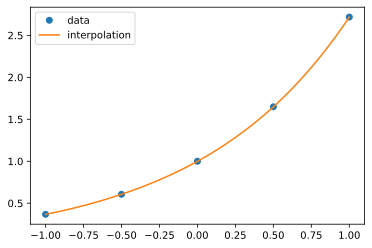

In [9]:
from scipy.interpolate import BarycentricInterpolator

n = 5 # number of points
t = np.linspace(-1, 1, n)
y = np.exp(t) # data points
p = BarycentricInterpolator(t, y) # interpolant
plt.plot(t, y, 'o', label='data')
tt = np.linspace(-1, 1, 100) # fine mesh for plotting
plt.plot(tt, p(tt), label='interpolation')
plt.legend()
plt.show()

## Newton Interpolation

- The Newton interpolating polynomial has the form
\begin{align}
p_{n-1}(t) &= \sum_{i=0}^{n-1} x_i \pi_i(t)\\ 
&= x_0 + x_1(t-t_0) + 
\cdots + x_{n-1}(t-t_0)\cdots(t-t_{n-2}),
\end{align}
where the _Newton basis functions_ are defined by
$$\pi_i(t) = \prod_{j=0}^{i-1} (t-t_j).$$

- Newton interpolation can be easily updated with successive data points. Let $x_0=y_0$. Using $p_{i+1}(t) = p_i(t) + x_{i+1}\pi_{i+1}(t)$ one can determine
$$x_{i+1} = \frac{y_{i+1} - p_i(t_{i+1})}{\pi_{i+1}(t_{i+1})}.$$


## Orthogonal Polynomials

- Two polynomials $p(t)$ and $q(t)$ on interval $[a, b]$ are orthogonal if their inner product
$$ (p, q) \equiv \int_a^b p(t) q(t) w(t)\,\mathrm{d} t$$
is 0, where $w(t)$ is a non-negative _weight function_.

- For a given set of polynomials and the weigth function $w(t)$, one can use the Gram-Schmidt procedure to construct a set of orthonormal polynomials that span the same function space.

- Orthogonal polynomials are useful in least squares fit, numerical integration, etc.

- [`numpy.polynomial`](https://numpy.org/doc/stable/reference/routines.polynomials.html) implements several commonly used orthogonal polynomials.

- _Legendre polynomials_ $L_i(t)$ on $[-1, 1]$ are generated with the weight function $w(t)=1$, and $L_i(t)$ is a polynomial of degree $i$.

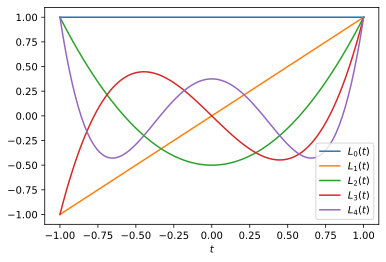

In [10]:
from numpy.polynomial.legendre import Legendre

t = np.linspace(-1, 1, 100)
for i in range(5):
    plt.plot(t, Legendre.basis(i)(t), label=f'$L_{i}(t)$')
plt.legend()
plt.xlabel('$t$')
plt.show()

- _Chebyshev polynomials_ $T_k=\cos(k\,\arccos(t))$ on $[-1, 1]$ are generated with the weight function $w(t)=(1-t^2)^{-1/2}$.
- Successive extrema of $T_k$ have the same magnitude but opposite signs which distribute error uniformly.

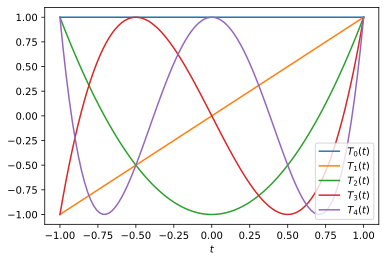

In [11]:
from numpy.polynomial.chebyshev import Chebyshev
t = np.linspace(-1, 1, 100)
for n in range(5):
    plt.plot(t, Chebyshev.basis(n)(t), label=f'$T_{n}(t)$')
plt.legend()
plt.xlabel('$t$')
plt.show()

- $T_k(t)$ is a polynomial of degree $k$ with roots 
$$ t_j =\cos[(2j-1)\pi/2 k], \quad(j=1,2,\ldots, k),$$
which are called _Chebyshev nodes_.

- Polynomial interpolation with Chebyshev nodes has better convergence than with equally spaced points.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7a/Chebyshev-nodes-by-projection.svg/500px-Chebyshev-nodes-by-projection.svg.png)
[Figure Credit: Wikimedia]

In [12]:
f = lambda t: 1/(1+25* t**2) # Runge's function
n = 11 # number of points

# polynomial interpolation with equal-spaced points 
t1 = np.linspace(-1, 1, n) 
y1 = f(t1)
p1 = BarycentricInterpolator(t1, f(t1))

# polynomial interpolation with Chebyshev nodes
t2 = np.cos([(2*k-1)*np.pi/(2*n) for k in range(1, n+1)])
y2 = f(t2)
p2 = BarycentricInterpolator(t2, y2)

# Chebyshev interpolation in numpy
p3 = Chebyshev.interpolate(f, deg=n-1)

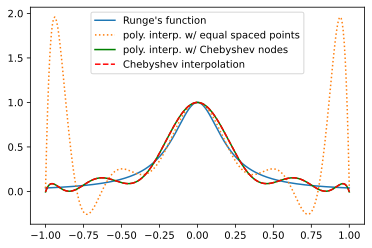

In [13]:
tt = np.linspace(-1, 1, 300)
plt.plot(tt, f(tt), label="Runge's function")
plt.plot(tt, p1(tt), ':', label='poly. interp. w/ equal spaced points')
plt.plot(tt, p2(tt), 'g-', label='poly. interp. w/ Chebyshev nodes')
plt.plot(tt, p3(tt), 'r--', label='Chebyshev interpolation')
plt.legend()
plt.show()

# Piecewise Polynomial Interpolation

- Fitting a large data set with a single polynomial can be problematic. _Piecewise polynomials_ can fit many data points with many low-degree polynomials.

- Different polynomials are used in different intervals $[t_i, t_{i+1}]$, where $t_i$'s are called _knots_ or _breakpoints_.

- A _spline_ of degree $k$ is made of piecewise polynomials of degree $k$ and has continuous derivatives up to order $k-1$.

- [`scipy.interpolate.InterpolatedUnivariateSpline`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.InterpolatedUnivariateSpline.html) implements spline interpolation of degrees $1\leq k \leq 5$.

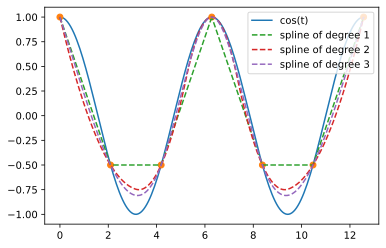

In [14]:
from scipy.interpolate import InterpolatedUnivariateSpline

# data points
t = np.linspace(0, 4*np.pi, 7)
y = np.cos(t) # data points

# compare results
tt = np.linspace(t[0], t[-1], 200)
plt.plot(tt, np.cos(tt), label='cos(t)')
plt.plot(t, y, 'o')
for k in range(1, 4):
    spl = InterpolatedUnivariateSpline(t, y, k=k)
    plt.plot(tt, spl(tt), '--', label=f'spline of degree {k}')
plt.legend()
plt.show()

- A _cubic spline_ is made of piecewise cubic polynomials and is twice continously differentiable.

- A cubic spline of $n$ knots has two free parameters which can be specified in different ways:
    - Force the third derives to be continuous at the 2nd knot ($t_1$) and the second to the last knots ($t_{n-2}$) (_not-a-knot_);
    - Set the first derivatives to be 0 at the endpoints (_clamped_);
    - Set the second derivatives to be 0 at the endpoints (_natural_);
    - Set the first and second derivatives to match at the endpoints (_periodic_).
    
- [`scipy.interpolate.CubicSpline`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html) implements the cubic spline.

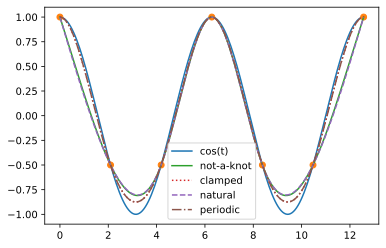

In [15]:
from scipy.interpolate import CubicSpline

# data points
t = np.linspace(0, 4*np.pi, 7)
y = np.cos(t)

# compare different boundary conditions
kinds = ['not-a-knot', 'clamped', 'natural', 'periodic']
linestyles = ['-', ':', '--', '-.']
tt = np.linspace(t[0], t[-1], 200)
plt.plot(tt, np.cos(tt), label='cos(t)')
plt.plot(t, y, 'o')
for k, l in zip(kinds, linestyles):
    spl = CubicSpline(t, y, bc_type=k)
    plt.plot(tt, spl(tt), l, label=k)
plt.legend()
plt.show()

- A _B-spline_ or _basis spline_ is a spline function that has minimal support with respect to a given degree, smoothness, and domain partition [[Wikipedia](https://en.wikipedia.org/wiki/B-spline)]:
$$ B_i^{(k)}(t) = v_i^{(k)}(t) B_i^{(k-1)}(t)+
[1-v_{i+1}^{(k)}(t)] B_{i+1}^{(k-1)}(t), $$
where $v_i^{(k)}(t)=(t-t_i)/(t_{i+k} - t_i)$, and $B_i^{(0)}(t)=1$ if $t_i\leq t \leq t_{i+1}$ and 0 otherwise.


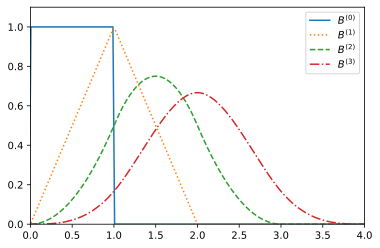

In [16]:
from scipy.interpolate import BSpline

t = np.linspace(-3, 7, 11)
c = np.zeros(11); c[3] = 1 # B-spline coefficients
tt = np.linspace(t[0], t[-1], 500)
for k,l in enumerate(linestyles):
    plt.plot(tt, BSpline(t, c, k)(tt), l, label=f'$B^{{({k})}}$')
    
plt.legend()
plt.xlim(0, 4)
plt.ylim(0, 1.1)
plt.show()

- B-splines have the following properties:
    - $B^{(k)}_i(t)>0$ for $t_i< t < t_{i+k+1}$ and is 0 otherwise (_local support_),
    - $\sum_i B^{(k)}_i(t)=1$ (normalized),
    - $k-1$ differentiable,
    - $\{B^{(k)}_{-k}, B^{(k)}_{-k+1}, \ldots, B^{(k)}_{n-1}\}$ form a complete and linearly independent basis for all the splines of degree $k$ on $[t_0, t_{n-1}]$ and with knots $t_i$.
    
- The linear system for solving the coefficients of B-splines is non-singular and banded.

- [`scipy.interpolate.make_interp_spline`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.make_interp_spline.html) implements the B-spline interpolation.

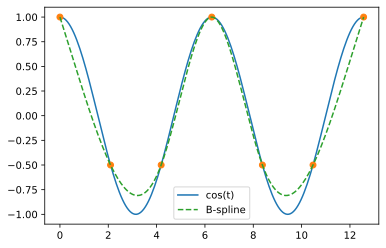

In [17]:
from scipy.interpolate import make_interp_spline

# data points
t = np.linspace(0, 4*np.pi, 7)
y = np.cos(t)

# compare results
tt = np.linspace(t[0], t[-1], 200)
plt.plot(tt, np.cos(tt), label='cos(t)')
plt.plot(t, y, 'o')
spl = make_interp_spline(t, y) # not-a-knot and k=3 by default
plt.plot(tt, spl(tt), "--", label="B-spline")
plt.legend()
plt.show()

# Homework 11

- Define a function or class that produces a degree-$(n-1)$ polynomial interpolant for any given $n$ data points $(t_i, y_i)$. 

- Interpolate Runge's function $f(t)=1/(1+25 t^2)$ with both the polynomial interpolant you implemented and a cubic spline on $[-1,1]$ with increasing number of equally-spaced points and compare the results.